In [1]:
import tensorflow as tf 
import cPickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [61]:
learning_rate = 0.0008
n_epochs = 20
batch_size = 500

## FUNCTIONS TO LOAD DATA
- The data is provided originally as rows of pixel intensity values for R,G and then B channels : According to the site: 
> *" A 10000x3072 numpy array of uint8's. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image "*

In [3]:
data_dir="CIFAR"

def unpickle(file):
    '''Load byte data from file'''
    with open(file, 'rb') as f:
        data = cPickle.load(f)
    return data


def load_cifar10_data():
    '''
    Return train_data, train_labels, test_data, test_labels
    The shape of data returned would be as it is in the data-set N X 3072

    We don't particularly need the metadata - the mapping of label numbers to real labels
    '''
    train_data = None
    train_labels = []

    for i in range(1, 6):
        data_dic = unpickle(data_dir + "/data_batch_"+str(i))
        if i == 1:
            train_data = data_dic['data']
        else:
            train_data = np.append(train_data, data_dic['data'])
        train_labels += data_dic['labels']

    test_data_dic = unpickle(data_dir + "/test_batch")
    test_data = test_data_dic['data']
    test_labels = test_data_dic['labels']
    names=unpickle(data_dir+'/batches.meta')
    
    return train_data, np.array(train_labels), test_data, np.array(test_labels), names['label_names']


In [34]:
train_data,train_labels,test_data,test_labels,names=load_cifar10_data()

In [ ]:
train_data.shape

### Lets see some sample images. 

- Isolate the image data by reshaping into form s.t 3072 pixel values form the columns values:
- Now, as suggested in the source site, all Red pixels are stored first, then  green and then blue. So, reshape using (3,32,32) as the target shape.
- Further, the matplotlib function needs it in different shape : it requires in the form of: width X height X channels and hence, we need to transpose it
- Change the *IMG_IDX* parameter to view different images

bird


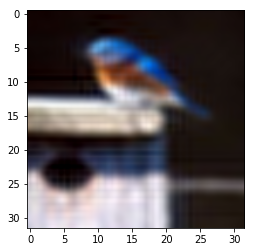

In [40]:
IMG_IDX=13
train_data_vis=train_data.reshape((-1,3072))
train_data_vis=train_data_vis[IMG_IDX].reshape(3,32,32).transpose([1, 2, 0])
plt.imshow(train_data_vis,interpolation='sinc')
print names[train_labels[IMG_IDX]]

## Building the model now:

- Each image is of size 32 X 32 X 3

In [62]:
features=tf.placeholder(tf.float32,shape=(None,3*1024)) # will store the train-set images in each of its rows
labels=tf.placeholder(tf.float32,shape=(None))

input_layer=tf.reshape(features,[-1,32,32,3]) # -1 is to derive the shape along that axis automatically

# Convolutional Layer #1
kernel_1 = tf.Variable(tf.random_normal([5,5,3,32]))
biases_1 = tf.Variable(tf.random_normal([32]))
conv1_ = tf.nn.conv2d(
    input_layer,
    kernel_1,
    [1,1,1,1],
    padding="VALID")

conv1=tf.nn.crelu(tf.nn.bias_add(conv1_,biases_1))

# Pooling Layer #1
pool1 = tf.nn.max_pool(conv1, [1,2,2,1], [1,1,1,1],"VALID")


In [70]:
pool3.shape

TensorShape([Dimension(None), Dimension(4), Dimension(4), Dimension(16)])

In [64]:
# Convolutional Layer #2 and Pooling Layer #2
kernel_2 = tf.Variable(tf.random_normal([5,5,64,64]))
biases_2=tf.Variable(tf.random_normal([64]))
conv2_ = tf.nn.conv2d(
    pool1,
    kernel_2,
    [1,1,1,1],
    padding="VALID")
conv2=tf.nn.crelu(tf.nn.bias_add(conv2_,biases_2))
pool2 = tf.nn.max_pool(conv2, [1,2,2,1], [1,2,2,1],"VALID")
pool2_flat=tf.reshape(pool2,[-1,11*11*128])
'''
# Convolutional Layer #3 and Pooling Layer #3
kernel_3 = tf.Variable(tf.random_normal([3,3,64,64]))
biases_3 = tf.Variable(tf.random_normal([64]))
conv3_ = tf.nn.conv2d(
    pool2,
    kernel_3,
    [1,1,1,1],
    padding="VALID")
conv3=tf.nn.relu(tf.nn.bias_add(conv3_,biases_3))
pool3 = tf.nn.max_pool(conv3, [1,2,2,1], [1,2,2,1],"VALID")

pool3_flat = tf.reshape(pool3, [-1, 4 * 4 * 64])
'''
dense1 = tf.layers.dense(inputs=pool2_flat, units=3072, activation=tf.nn.crelu)
dense2 = tf.layers.dense(inputs=dense1, units=1012, activation=tf.nn.crelu)
dense3 = tf.layers.dense(inputs=dense2, units=200, activation=tf.nn.crelu)

# we have only 10 classes to classify
logits = tf.layers.dense(inputs=dense3, units=10)

# finding the class wiht max probability
predictions = tf.argmax(input=logits, axis=1)
onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=10)
loss = tf.losses.softmax_cross_entropy(onehot_labels=onehot_labels, logits=logits)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)


accu = tf.metrics.accuracy(labels=labels, predictions=predictions)
init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()

In [49]:
print logits.shape
print onehot_labels.shape
print labels.shape
print predictions.shape
print train_labels.shape

(?, 10)
<unknown>
<unknown>
(?,)
(50000,)


### Trying to visualize the computation graph using TensorBoard

In [50]:
sess=tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

writer_1 = tf.summary.FileWriter("/tmp/cnn/train")
writer_1.add_graph(sess.graph)
sess.close()

**Now, run the following to initiate TensorBoard Server:**  
> tensorboard --logdir="/tmp/cnn/"






**Then, in the browser, open: **
> localhost:6006

In [35]:
print train_data.reshape((-1,3072)).shape
print train_data_split[0].shape

(50000, 3072)
(100, 3072)


### Training the graph

In [65]:
sess=tf.Session()
sess.run(init_g)
sess.run(init_l)

#############################  The real training stage begins here ##############################################
train_data = train_data.reshape(-1,3072)
rand_index = np.arange(len(train_data))
for j in range(n_epochs):
    np.random.shuffle(rand_index)
    train_data=train_data[rand_index]
    train_labels=train_labels[rand_index]
    train_data_split=np.split(train_data,batch_size)
    train_labels_split=np.split(train_labels,batch_size)
    n_batches = len(train_data_split)
    for i in range(n_batches):
        batch_x = train_data_split[i]
        batch_y = train_labels_split[i]
        sess.run(train_step, feed_dict={features: batch_x, labels: batch_y})
        # finding E_out at the end of each epoch
    E_out=sess.run(accu,feed_dict={features: test_data.reshape((-1,3072)), labels: test_labels})
    print "epoch:",j,": E_out:",
    print E_out
    #print("{0:.4f}".format(E_out)) 

epoch: 0 : E_out: (0.0, 0.3819)
epoch: 1 : E_out: (0.3819, 0.3738)
epoch: 2 : E_out: (0.3738, 0.39983332)
epoch: 3 : E_out: (0.39983332, 0.423275)
epoch: 4 : E_out: (0.423275, 0.42434)
epoch: 5 : E_out: (0.42434, 0.43576667)
epoch: 6 : E_out: (0.43576667, 0.43744287)
epoch: 7 : E_out: (0.43744287, 0.4266875)
epoch: 8 : E_out: (0.4266875, 0.42281112)
epoch: 9 : E_out: (0.42281112, 0.43055)
epoch: 10 : E_out: (0.43055, 0.43853638)
epoch: 11 : E_out: (0.43853638, 0.43990833)
epoch: 12 : E_out: (0.43990833, 0.4418077)
epoch: 13 : E_out: (0.4418077, 0.4467643)
epoch: 14 : E_out: (0.4467643, 0.45150667)
epoch: 15 : E_out: (0.45150667, 0.45600626)
epoch: 16 : E_out: (0.45600626, 0.45564118)
epoch: 17 : E_out: (0.45564118, 0.45731667)
epoch: 18 : E_out: (0.45731667, 0.45809475)
epoch: 19 : E_out: (0.45809475, 0.45965)


***
**Considering that we had 10 classes, ~46% accuracy is not too bad. Further tinkering with the layers, and even running**

**for more epochs is likely to lead to much better performance**

***

### Saving the model for later use:

In [70]:
import os
cwd = os.getcwd()
print cwd
saver = tf.train.Saver()
save_path = saver.save(sess, cwd+"/model_CIFAR.ckpt")
print("Model saved in path: %s" % save_path)

/home/bt3/15CS10057/personal_projects
Model saved in path: /home/bt3/15CS10057/personal_projects/model_CIFAR.ckpt


**Could be restored as:**

```python
import os
cwd = os.getcwd()
saver = tf.train.Saver()
with tf.Session() as sess:
     saver.restore(sess, cwd+"model_CIFAR.ckpt")
```

In [22]:
sess.close()